In [1]:
cd /home

/home


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pandas as pd
import os

from tensorflow.keras.optimizers import Adam
from tensorboard.backend.event_processing import event_accumulator
from src.preprocess import preprocess_folder
from tensorflow.core.util import event_pb2
from src.record import load_records
from src.model import create_model
from src.losses import coords_rmse
from src.format_data import create_dataset
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

%load_ext autoreload
%autoreload 2

2023-07-01 02:51:17.853856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 02:51:17.982951: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.8/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://

In [3]:
test_ds = load_records('./data/records/coords/fold_0/test.record')

2023-07-01 02:51:21.188755: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-01 02:51:21.629335: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22316 MB memory:  -> device: 0, name: A30, pci bus id: 0000:41:00.0, compute capability: 8.0


In [4]:
def get_metrics(path_logs, metric_name='epoch_loss', full_logs=True, show_keys=False):
    train_logs = [x for x in os.listdir(path_logs) if x.endswith('.v2')][-1]
    path_train = os.path.join(path_logs, train_logs)

    if full_logs:
        ea = event_accumulator.EventAccumulator(path_train, size_guidance={'tensors': 0})
    else:
        ea = event_accumulator.EventAccumulator(path_train)

    ea.Reload()

    if show_keys:
        print(ea.Tags())

    metrics = pd.DataFrame([(w,s,tf.make_ndarray(t))for w,s,t in ea.Tensors(metric_name)],
                columns=['wall_time', 'step', 'value'])
    return metrics

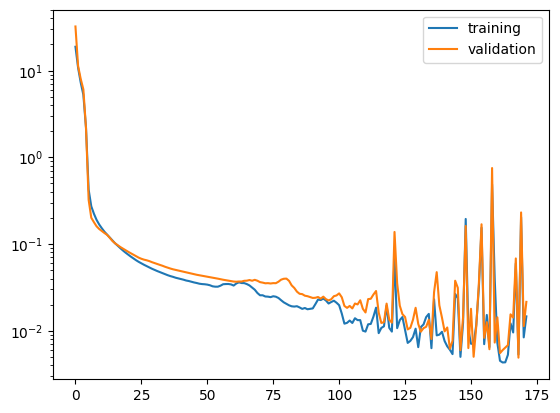

In [5]:
logs_train = get_metrics('./logs/test/Lino/logs/train/')
logs_val = get_metrics('./logs/test/Lino/logs/validation/')

plt.plot(logs_train['value'], label='training')
plt.plot(logs_val['value'], label='validation')
plt.legend()
plt.yscale('log')
plt.show()

In [6]:
model = create_model(63)
model.load_weights('./logs/test/Lino/weigths')

In [7]:
optimizer = Adam(1e-3)
model.compile(loss_fn=coords_rmse)

In [8]:
# model.summary()

In [9]:
model.evaluate(test_ds)

2023-07-01 02:51:23.714954: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


51/51 [==============================] - 2s 4ms/step - loss: 0.0045


2023-07-01 02:51:24.777219: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


0.003385893302038312

In [10]:
x = np.random.normal(size=[1, 63, 63,1])


In [11]:
for x, y in test_ds:
    print(x.shape)
    y_pred = model(x)
    
    print(y_pred)
    print(y)
    break

(2, 63, 63, 1)
tf.Tensor(
[[35.912262 34.0193  ]
 [32.97909  27.954979]], shape=(2, 2), dtype=float32)
tf.Tensor(
[[36 34]
 [33 28]], shape=(2, 2), dtype=int64)


### real data

In [12]:
cube, psf, rot_angles, table = preprocess_folder(root='./data/real/DHTau/', 
                                                 target_folder='./data/real/DHTau/preprocessed')

[INFO] Restoring saved values


In [33]:
from vip_hci.preproc.derotation import cube_derotate

In [35]:
cube_derot = cube_derotate(cube[0], rot_angles,  imlib='opencv', interpolation='nearneig')

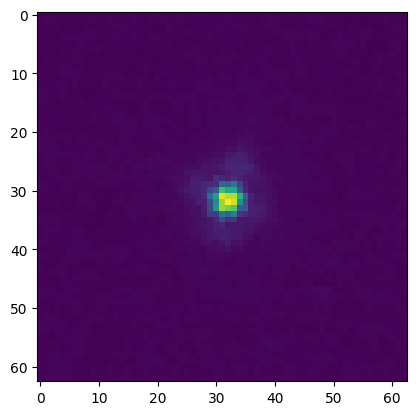

In [52]:
for index, row in table.iterrows():
    
    n_frams, width, height = cube_derot.shape
    
    left  = int(row['x'] - 63//2)
    right = int(row['x'] + 63//2) + 1

    up  = int(row['y'] - 63//2)
    down = int(row['y'] + 63//2) + 1
    cropped = cube_derot[:, up:down, left:right]
    
    y_pred = model(cropped)
    plt.imshow(cropped[0])
#     plt.scatter(, row['y'])
    break